In [2]:
import modal
import polars as pl
import requests
import zipfile
import io
import seaborn as sns
from lib.viz import count_plot
from markdownify import markdownify as md
from matplotlib import pyplot as plt
from collections import Counter  

In [8]:
labeled_path = "../data/labeled/25_07/to_classify.parquet"
df = pl.read_parquet(labeled_path)
df.schema
label_col = "label_majority"

In [ ]:
labels = df[label_col]
label_counts = Counter(labels)
label_counts_perc = {k: round((v / len(labels)) * 100, 2) for k, v in label_counts.items().__reversed__()}
print(f"Label Distribution: {label_counts}")
print(f"Label Distribution in %: {label_counts_perc}")

75
Label Distribution: Counter({0: 234, 1: 75})
Label Distribution in %: {1: 24.27, 0: 75.73}


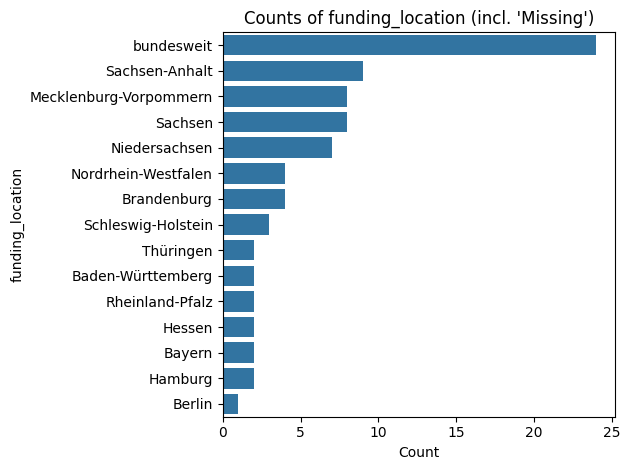

In [ ]:
positives = df.filter(pl.col("label") == 1)
count_plot(positives, "funding_location")

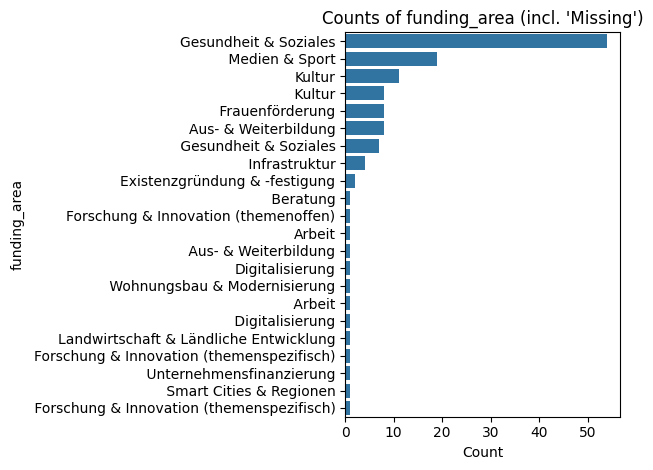

In [ ]:
count_plot(positives, "funding_area")

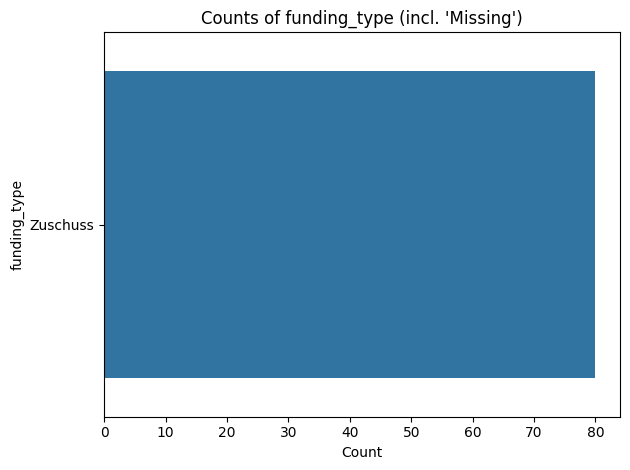

In [ ]:
count_plot(positives, "funding_type")

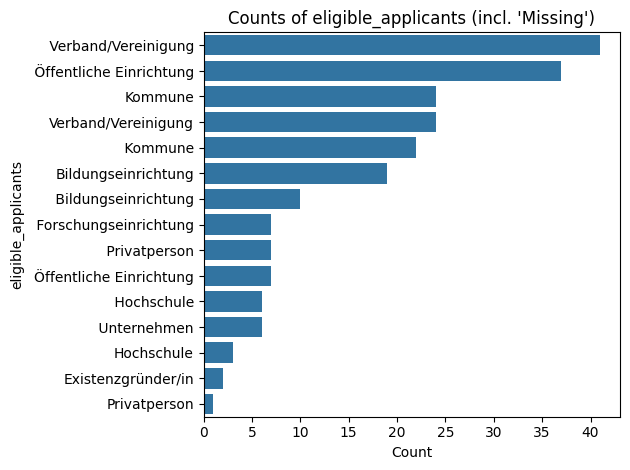

In [ ]:
count_plot(positives, "eligible_applicants")

In [ ]:
data_url = "https://foerderdatenbankdump.fra1.cdn.digitaloceanspaces.com/data/parquet_data.zip"

response = requests.get(data_url)
response.raise_for_status()

with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    file_name = z.namelist()[0]
    with z.open(file_name) as f:
        df_all = pl.read_parquet(f)

There are five main types of funding program description formatting types:

In [ ]:
patterns = {
    'Volltext': pl.col("description").str.contains("Volltext") & pl.col("description").str.contains("Kurztext"),
    'Kurztext_only': pl.col("description").str.contains("Kurztext") & ~pl.col("description").str.contains("Volltext"),
    'Volltext_only': pl.col("description").str.contains("Volltext") & ~pl.col("description").str.contains("Kurztext"),
    'Ziel': pl.col("description").str.contains("Ziel und Gegenstand"),
    'description_rechtgrundlage': pl.col("description").str.contains("Rechtsgrundlage")
}

patterns["unknown_description_pattern"] = ~(patterns["Volltext"] | patterns["Kurztext_only"] | patterns["Volltext_only"] | patterns["Ziel"] | patterns["description_rechtgrundlage"])

for name, condition in patterns.items():
    lbl_count = len(df.filter(condition))
    all_count = len(df_all.filter(condition))

    print(f"{name} pattern for labeled: {lbl_count}/{len(df)}; Percentage: {lbl_count / len(df):.4f}")
    print(f"{name} pattern for all: {all_count}/{len(df_all)}; Percentage: {all_count / len(df_all):.4f}\n")


NameError: name 'pl' is not defined